In [ ]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

base_path = "/content/drive/MyDrive/Facultate/master/pml_proiect2/"
file_name = "religion_posts.csv"

data = pd.read_csv(base_path + file_name)

print(data.head())

    index                                           Document subreddit
0  527941  I was raised as a Muslim, but never got into t...     islam
1  534235  \nAs salamu alaikum, I wonder what the benefit...     islam
2  531104  I was at a coffee shop when I saw a carbonara ...     islam
3  525922  Hello, so I am a 13 year old boy, naturally I ...     islam
4  523640  We intend to get married soon but my father an...     islam


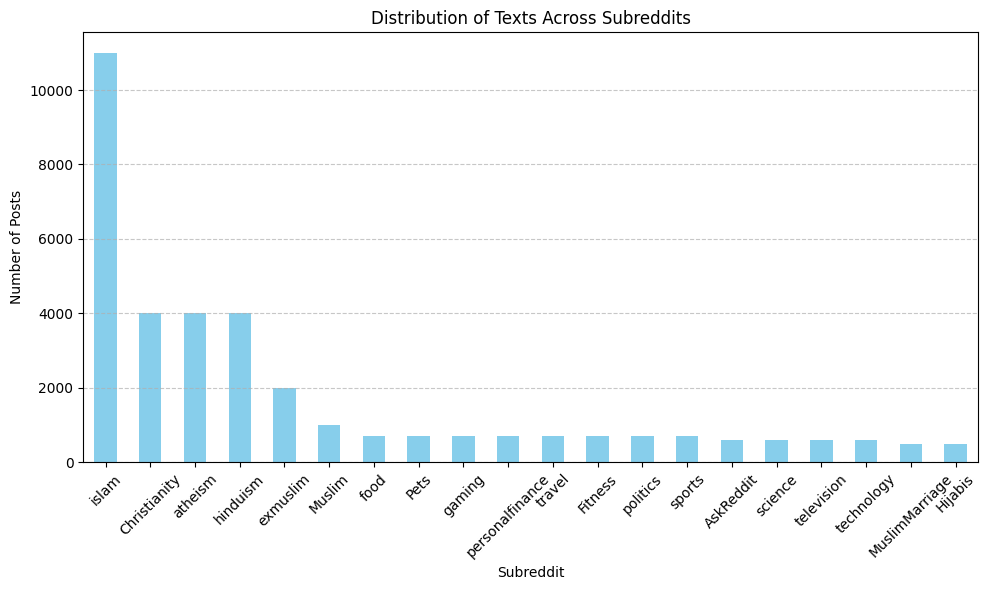

subreddit
islam              11000
Christianity        4000
atheism             4000
hinduism            4000
exmuslim            2000
Muslim              1000
food                 700
Pets                 700
gaming               700
personalfinance      700
travel               700
Fitness              700
politics             700
sports               700
AskReddit            600
science              600
television           600
technology           600
MuslimMarriage       500
Hijabis              500
Name: count, dtype: int64


In [ ]:
class_distribution = data['subreddit'].value_counts()

plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Texts Across Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(class_distribution)


In [ ]:
classes = ["food", "Fitness", "hinduism", "travel"]

        index                                           Document subreddit
15000  321180  I realize that title is dark. But she's alread...      food
15001  320564  I have been looking into opening a comfort foo...      food
15002  322263  My favorite salad dressing is Newman Italian b...      food
15003  318813  Hi all!\n\nI am from the US, North Carolina to...      food
15004  319011  Every morning I make breakfast at work.  Since...      food
subreddit
hinduism    4000
food         700
travel       700
Fitness      700
Name: count, dtype: int64


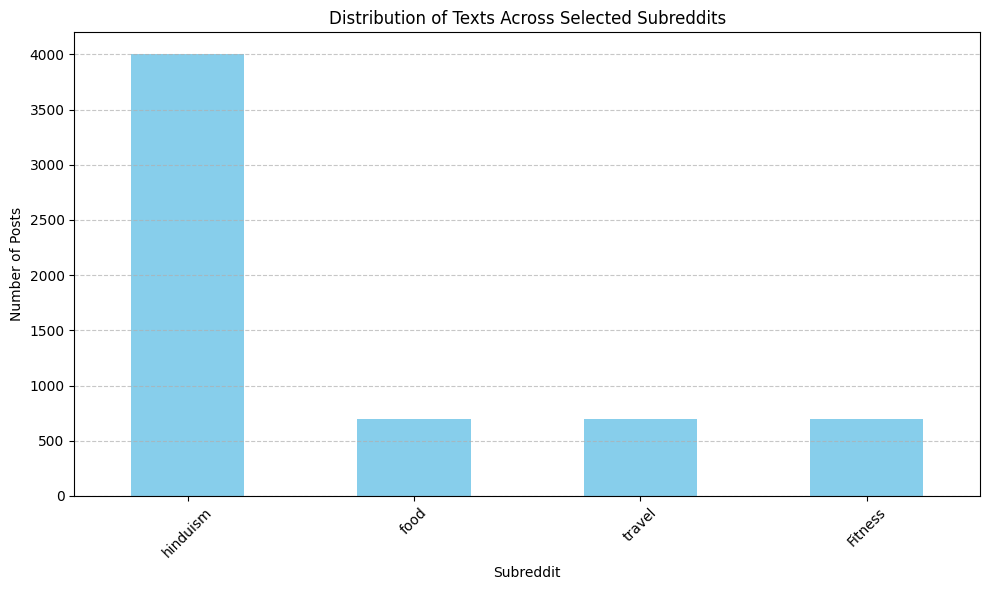

In [ ]:

filtered_data = data[data['subreddit'].isin(classes)]
print(filtered_data.head())

class_distribution_filtered = filtered_data['subreddit'].value_counts()
print(class_distribution_filtered)

plt.figure(figsize=(10, 6))
class_distribution_filtered.plot(kind='bar', color='skyblue')
plt.title('Distribution of Texts Across Selected Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

sampled_data = pd.DataFrame()
for class_name in classes:
    class_data = filtered_data[filtered_data['subreddit'] == class_name]
    sample = class_data.sample(n=min(500, len(class_data)), random_state=42)  # Set random_state for reproducibility

    sampled_data = pd.concat([sampled_data, sample], ignore_index=True)

print(sampled_data.head())
print(sampled_data['subreddit'].value_counts())

    index                                           Document subreddit
0  316536  My friend says he can understand Japanese seaf...      food
1  316211  Hosting a dinner party next week and I really ...      food
2  316678  I eat a pint of B&amp;J every night. I always ...      food
3  316669  Now don't get me wrong: I love the the damned ...      food
4  322392  Hi fellow Redditors,\n\nFirst post here. Recen...      food
subreddit
food        500
Fitness     500
hinduism    500
travel      500
Name: count, dtype: int64


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:

x = sampled_data['Document']
y = sampled_data['subreddit']

In [ ]:
!pip install emoji
!pip install nltk
import nltk
nltk.download('stopwords')


In [ ]:
import re
import emoji
from nltk.corpus import stopwords

def preprocess_text(text, language='english'):
    text = re.sub(r'http\S+|www\.\S+', '', text)

    text = emoji.demojize(text)

    text = text.lower()

    tokens = re.split(r'\W+', text)
    tokens = [t for t in tokens if t.strip() != '']
    stop_words = set(stopwords.words(language))
    tokens = [t for t in tokens if t not in stop_words]

    tokens = [t for t in tokens if not t.isdigit()]

    return tokens


In [ ]:
x = x.apply(preprocess_text)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=x_train,
    vector_size=150,
    window=5,
    min_count=1,
    sg=1,
    workers=4
)

model.train(x_train, total_examples=len(x_train), epochs=10)

model.save("word2vec_model.model")

similar_words = model.wv.most_similar("sport")
print(similar_words)


[('aiming', 0.9357764720916748), ('1lb', 0.9319590926170349), ('increased', 0.9242956638336182), ('regimen', 0.924083948135376), ('leangains', 0.9157534837722778), ('steadily', 0.9146125316619873), ('basketball', 0.9142025709152222), ('hockey', 0.9098814725875854), ('fever', 0.9081345200538635), ('lifted', 0.9077181220054626)]


In [ ]:
import numpy as np

def document_to_vector(doc, model):

    vectors = []
    for word in doc:
        if word in model.wv:
            vectors.append(model.wv[word])
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def documents_to_vectors(docs, model):

    return np.array([document_to_vector(doc, model) for doc in docs])

x_train_vectors = documents_to_vectors(x_train, model)
x_test_vectors = documents_to_vectors(x_test, model)

print(x_train_vectors.shape)

(1600, 150)
